# Notebook for data preparation and visualization

In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn import decomposition
warnings.simplefilter('ignore')
#line to print the plots here
%matplotlib inline
#Render images
%config inlineBackend.figure_format = 'svg'
folder_Firebrowse_GBM="Data/Firebrowse_GBM/"

### Data Provenance

All Data except for the RNASeq data was downloaded with RTCGAToolbox with the code TCGADownload.R that is in the Github Repository: https://github.com/CamilaDuitama/MasterThesis/blob/master/DownloadTCGA.R

RNASeq data was downloaded directly from the Firebrowse website: http://firebrowse.org/?cohort=GBM

√ Clinical Data

√ RNA Microarray Data

√ MicroArray miRNA

√ Methylation

√ Copy Number (GISTIC)

√ RNASeq

### Clinical Data

In [84]:
clinical= pd.read_csv(folder_Firebrowse_GBM+"Clinical.csv", sep=",",header=0,index_col=0)
clinical["years_to_birth"] = clinical["years_to_birth"].apply(pd.to_numeric)
clinical["days_to_death"] = clinical["days_to_death"].apply(pd.to_numeric)
clinical["date_of_initial_pathologic_diagnosis"] = clinical["date_of_initial_pathologic_diagnosis"].apply(pd.to_numeric)
clinical["karnofsky_performance_score"] = clinical["karnofsky_performance_score"].apply(pd.to_numeric)
clinical["vital_status"] = clinical["vital_status"].apply(pd.to_numeric)
clinical=clinical.drop(columns=['Composite Element REF'])
new_index=pd.Series([w.replace(".","-").upper() for w in clinical.index.tolist()])
clinical.set_index(new_index,inplace=True)
clinical.head()

,years_to_birth,vital_status,days_to_death,days_to_last_followup,tumor_tissue_site,gender,date_of_initial_pathologic_diagnosis,radiation_therapy,karnofsky_performance_score,histological_type,race,ethnicity
TCGA-06-6391,44,1,45.0,NaN,brain,female,2011,no,NaN,untreated primary (de novo) gbm,white,not hispanic or latino
TCGA-19-A6J4,68,1,121.0,NaN,brain,male,2013,NaN,NaN,glioblastoma multiforme (gbm),black or african american,not hispanic or latino
TCGA-06-1806,47,1,466.0,NaN,brain,male,2009,yes,90.0,glioblastoma multiforme (gbm),white,not hispanic or latino
TCGA-06-5408,54,1,357.0,NaN,brain,female,2009,yes,80.0,untreated primary (de novo) gbm,white,not hispanic or latino
TCGA-06-5410,72,1,108.0,NaN,brain,female,2010,no,60.0,untreated primary (de novo) gbm,white,not hispanic or latino


In [85]:
clinical.shape

(595, 12)

In [86]:
clinical_description=clinical.describe()
clinical_description.head(10)

,years_to_birth,vital_status,days_to_death,days_to_last_followup,date_of_initial_pathologic_diagnosis,karnofsky_performance_score
count,595.000000,595.000000,490.000000,102.000000,595.000000,442.000000
mean,57.816807,0.825210,504.500000,479.392157,2004.815126,77.036199
std,14.416311,0.380107,538.727567,540.490283,5.042524,15.621473
min,10.000000,0.000000,3.000000,0.000000,1989.000000,0.000000
25%,50.000000,1.000000,170.500000,156.250000,2002.000000,70.000000
50%,59.000000,1.000000,382.000000,261.000000,2006.000000,80.000000
75%,68.000000,1.000000,609.250000,628.000000,2009.000000,80.000000
max,89.000000,1.000000,3881.000000,2818.000000,2013.000000,100.000000


In [87]:
clinical["days_to_death"].isna().sum()

105

In [91]:
#Code to mark the samples in mRNAArray as one of the four subclasses of GBM or as other, and assign a color to them
result=list()
for i in clinical.index.tolist():
    if i in labels["CLID"].tolist():
        index=labels["CLID"].tolist().index(i)
        result.append(labels.loc[index,"Subtype"])
    else:
        result.append("Other")
result=pd.DataFrame(result,columns=["target"])
result.head()

,target
0,Other
1,Other
2,Other
3,Other
4,Other


Text(0.5, 1.0, 'Histogram of Tumour subtypes in Clinical Data for Firebrowse GBM')

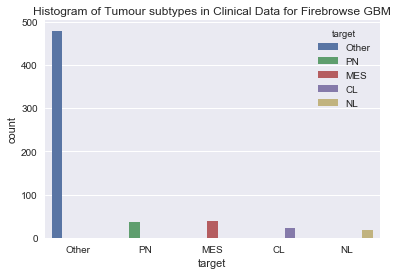

In [92]:
ax = sns.countplot(x="target", data=result,hue="target")
ax.set_title("Histogram of Tumour subtypes in Clinical Data for Firebrowse GBM")

#### Vital status

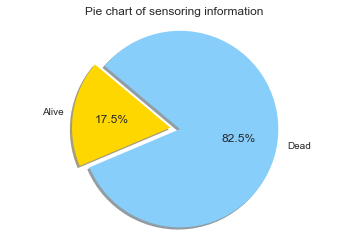

In [93]:
vital_status=clinical["vital_status"].apply(int)
ones=vital_status.sum()
zeroes=len(vital_status)-ones
# Data to plot
labels = 'Alive', 'Dead'
sizes = [zeroes,ones]
colors = ['gold', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Pie chart of sensoring information")
plt.axis('equal')
plt.show()

## RNA Microarray data

In [12]:
mRNAArray= pd.read_csv(folder_Firebrowse_GBM+'gdac.broadinstitute.org_GBM.Merge_transcriptome__ht_hg_u133a__broad_mit_edu__Level_3__gene_rma__data.Level_3.2016012800.0.0.csv', sep=",",header=0,index_col=0)
mRNAArray=mRNAArray.apply(pd.to_numeric)
mRNAArray=mRNAArray.transpose()
mRNAArray.head()

,AACS,FSTL1,ELMO2,CREB3L1,RPS11,PNMA1,MMP2,SAMD4A,SMARCD3,A4GNT,...,KIAA0802,DHRS2,RAB8A,SGEF,PIK3IP1,RPS27,SNRPD2,SLC39A6,CTSC,AQP7
TCGA-02-0001-01C-01R-0177-01,6.500551,8.729663,5.511362,4.882953,10.984784,7.535193,8.674010,5.032552,4.710970,5.108478,...,7.031196,7.153611,9.048851,4.366050,6.054001,12.91192,11.87229,6.867686,10.35408,4.709882
TCGA-02-0003-01A-01R-0177-01,6.539245,9.794400,6.213981,4.836276,10.811245,6.997933,9.348590,5.026961,5.327734,4.348606,...,6.305493,4.006913,8.864498,4.385314,6.674161,13.41945,11.10971,8.147826,11.36744,4.196368
TCGA-02-0004-01A-01R-0298-01,7.377848,12.059550,7.051738,6.112444,10.436374,9.132060,11.248461,5.559116,8.268237,4.052377,...,5.948139,4.025056,8.845742,4.814875,6.464478,13.22964,11.32098,8.519248,10.37950,3.733875
TCGA-02-0007-01A-01R-0177-01,7.186891,4.945053,5.230444,5.818606,10.477304,8.356117,4.429521,5.175938,4.440470,4.824183,...,6.502366,4.290511,8.483590,4.798488,5.060176,13.57505,11.66559,9.189867,11.47816,4.323108
TCGA-02-0009-01A-01R-0177-01,7.675038,10.840095,6.620676,5.333213,10.637267,6.942901,9.452231,5.164914,4.952207,4.204604,...,5.142545,5.410476,9.239238,4.343192,6.478035,13.28695,11.48040,8.556436,10.40471,4.639090


In [13]:
mRNA_description=mRNAArray.describe()
mRNA_description.head(8)

,AACS,FSTL1,ELMO2,CREB3L1,RPS11,PNMA1,MMP2,SAMD4A,SMARCD3,A4GNT,...,KIAA0802,DHRS2,RAB8A,SGEF,PIK3IP1,RPS27,SNRPD2,SLC39A6,CTSC,AQP7
count,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,...,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000
mean,6.857476,9.698384,7.033371,4.798021,10.717471,9.540024,7.712223,5.563474,8.322169,4.381581,...,6.626050,4.238019,8.659857,5.479921,6.061114,13.092543,11.220665,8.878248,9.053156,3.858680
std,0.580120,1.057241,0.685507,0.498979,0.393487,0.821276,1.175252,0.379776,1.036997,0.197806,...,0.815168,0.566826,0.636302,0.883631,0.601656,0.323572,0.535032,0.725665,1.191136,0.229216
min,5.536622,3.662355,4.930723,3.931335,9.643697,5.443112,3.793852,4.827805,3.674979,3.892355,...,4.677598,3.651946,5.843530,3.919830,4.478297,11.663410,8.858079,5.673272,5.499304,3.359786
25%,6.486874,9.152143,6.675970,4.422475,10.451898,9.213701,7.095800,5.286227,7.972591,4.230066,...,6.044459,4.008728,8.338326,4.827340,5.621027,12.900925,10.869718,8.501845,8.345613,3.696529
50%,6.829574,9.835648,7.057627,4.737883,10.653345,9.663865,7.779782,5.557519,8.500311,4.369468,...,6.627615,4.120118,8.735155,5.321490,6.019332,13.119180,11.248215,8.956953,9.071602,3.828434
75%,7.155040,10.396886,7.499242,5.036134,10.913628,10.067844,8.441331,5.777569,8.981484,4.499589,...,7.107896,4.260605,9.089152,5.950113,6.468787,13.329415,11.603428,9.333969,9.870845,3.978039
max,9.394954,12.059550,8.919199,8.120004,12.143343,11.417741,11.248461,7.825115,10.265944,5.231504,...,9.927499,10.938660,10.077050,8.402981,8.172227,13.829120,12.644980,11.507750,12.033930,5.174750


In [14]:
mRNAArray.shape

(538, 12042)

In [15]:
def hist_col(label:str,df:pd.core.frame.DataFrame, description:pd.core.frame.DataFrame):
    """
    Function to plot the histogram of a column in a dataframe with its corresponding description

    Arguments:

    label: String that corresponds to the name of the column being analysed
    df: Dataframe that contains the column label
    description: Dataframe that comes as the output of df.describe()
    """
    # the histogram of the data
    mu=description.loc["mean",label]
    sigma=description.loc["std",label]
    num_bins = "auto"

    n, bins, patches = plt.hist(df[label], num_bins, normed=1, facecolor='blue', alpha=0.5)

    # add a 'best fit' line

    y = mlab.normpdf(bins, mu, sigma)
    plt.plot(bins, y, 'r--')
    plt.title(r'Histogram of '+label+' : $\mu='+str(mu)+'$, $\sigma='+str(sigma)+'$')

    # Tweak spacing to prevent clipping of ylabel
    plt.subplots_adjust(left=0.15)
    plt.show()
    return


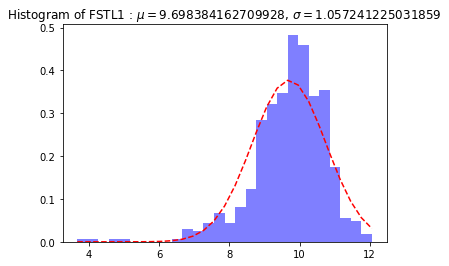

In [16]:
hist_col("FSTL1",mRNAArray,mRNA_description)

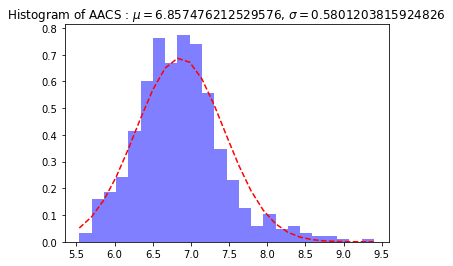

In [17]:
hist_col("AACS",mRNAArray,mRNA_description)

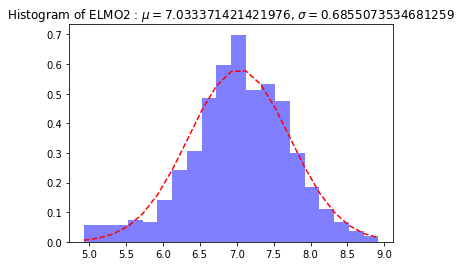

In [18]:
hist_col("ELMO2",mRNAArray,mRNA_description)

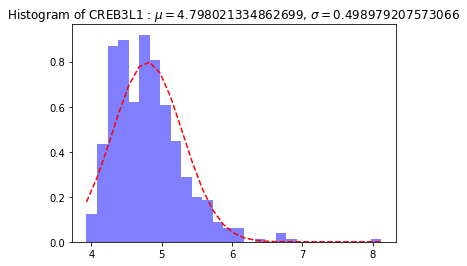

In [19]:
hist_col("CREB3L1",mRNAArray,mRNA_description)

## Comparison with Verhaak Gene Signature and Verhaak Sample

In [20]:
Sample_status=pd.read_csv('Sample_status.txt', sep="\t",header=0,index_col=0)
Sample_status.tail(10)

,Subtype,IDH1mut
CLID,,
TCGA-08-0375,CL,wt
TCGA-08-0380,NL,wt
TCGA-08-0385,PN,wt
TCGA-08-0386,NL,wt
TCGA-08-0390,MES,wt
TCGA-08-0392,MES,wt
TCGA-12-0616,PN,wt
TCGA-12-0618,PN,wt
TCGA-12-0619,MES,wt


In [21]:
Veerhak_GS=pd.read_csv('Verhaak_gene_signature.csv', sep=";",header=0,index_col=0)
Veerhak_GS=pd.DataFrame(Veerhak_GS.index.tolist())
Veerhak_GS.columns=["Gene Symbol"]
Veerhak_GS.head()

,Gene Symbol
0,CDKN1B
1,EPB41
2,CLGN
3,PDE10A
4,RALGPS2


In [22]:
mRNAArray_genes=pd.DataFrame(mRNAArray.columns.tolist())
mRNAArray_genes.columns=["Gene Symbol"]
Veerhak_GS_match=pd.merge(mRNAArray_genes,Veerhak_GS,how="left",on="Gene Symbol",indicator=True)

In [23]:
sum(Veerhak_GS_match["_merge"]=="both")

840

In [24]:
#Note: All Genes in the Verhaak signature are in the mRNA dataset

In [25]:
def check(df1: pd.DataFrame, df2: pd.DataFrame):
    """
    Function to check if the ids in one dataframe are also on the other dataframe  Arguments:
    df1= Larger dataframe
    df2= Smaller dataframe
    """
    
    d=dict()
    for x in df1.index.tolist():
        d[x]=list() 
    for i in df1.index.tolist():
        for j in df2.index.tolist():
            if i in j:
                d[i]=j
    return d

In [26]:
d=check(Sample_status,mRNAArray)
d

{'TCGA-02-0003': 'TCGA-02-0003-01A-01R-0177-01',
 'TCGA-02-0004': 'TCGA-02-0004-01A-01R-0298-01',
 'TCGA-02-0006': [],
 'TCGA-02-0007': 'TCGA-02-0007-01A-01R-0177-01',
 'TCGA-02-0009': 'TCGA-02-0009-01A-01R-0177-01',
 'TCGA-02-0010': 'TCGA-02-0010-01A-01R-0177-01',
 'TCGA-02-0011': 'TCGA-02-0011-01B-01R-0177-01',
 'TCGA-02-0014': 'TCGA-02-0014-01A-01R-0177-01',
 'TCGA-02-0016': 'TCGA-02-0016-01A-01R-0298-01',
 'TCGA-02-0021': 'TCGA-02-0021-01A-01R-0177-01',
 'TCGA-02-0023': 'TCGA-02-0023-01B-01R-0298-01',
 'TCGA-02-0024': 'TCGA-02-0024-01B-01R-0177-01',
 'TCGA-02-0025': 'TCGA-02-0025-01A-01R-0298-01',
 'TCGA-02-0026': 'TCGA-02-0026-01B-01R-0298-01',
 'TCGA-02-0027': 'TCGA-02-0027-01A-01R-0177-01',
 'TCGA-02-0028': 'TCGA-02-0028-01A-01R-0177-01',
 'TCGA-02-0033': 'TCGA-02-0033-01A-01R-0177-01',
 'TCGA-02-0034': 'TCGA-02-0034-01A-01R-0177-01',
 'TCGA-02-0038': 'TCGA-02-0038-01A-01R-0177-01',
 'TCGA-02-0039': 'TCGA-02-0039-01A-01R-0298-01',
 'TCGA-02-0043': 'TCGA-02-0043-01A-01R-0177-01',

In [27]:
#Just 2 of the Verhaak samples aren't in the FireBrowse Database of GBM data

From here on I had to find the equivalence between the patient IDs used by Verhaak and the ones on the Firebrowse TCGA data set

In [97]:
Verhaak_id=list()
Firebrowse_id=list()
for each in d.keys():
    if len(d[each])>0:
        Verhaak_id.append(each)
        Firebrowse_id.append(d[each])
    else:
        Verhaak_id.append(each)
        Firebrowse_id.append(None)
dummie=pd.DataFrame()
dummie["CLID"]=Verhaak_id
dummie["Hybridization REF"]=Firebrowse_id
dummie.head()

,CLID,Hybridization REF
0,TCGA-02-0003,TCGA-02-0003-01A-01R-0177-01
1,TCGA-02-0004,TCGA-02-0004-01A-01R-0298-01
2,TCGA-02-0006,None
3,TCGA-02-0007,TCGA-02-0007-01A-01R-0177-01
4,TCGA-02-0009,TCGA-02-0009-01A-01R-0177-01


In [98]:
labels=dummie.merge(Sample_status, how="left", left_on="CLID",right_index=True)
labels.head()

,CLID,Hybridization REF,Subtype,IDH1mut
0,TCGA-02-0003,TCGA-02-0003-01A-01R-0177-01,PN,wt
1,TCGA-02-0004,TCGA-02-0004-01A-01R-0298-01,MES,wt
2,TCGA-02-0006,None,MES,wt
3,TCGA-02-0007,TCGA-02-0007-01A-01R-0177-01,PN,wt
4,TCGA-02-0009,TCGA-02-0009-01A-01R-0177-01,CL,wt


In [99]:
#Code to mark the samples in mRNAArray as one of the four subclasses of GBM or as other, and assign a color to them
result=list()
for i in mRNAArray.index.tolist():
    if i in labels["Hybridization REF"].tolist():
        index=labels["Hybridization REF"].tolist().index(i)
        result.append(labels.loc[index,"Subtype"])
    else:
        result.append("Other")
result=pd.DataFrame(result,columns=["target"])
result.head()

,target
0,Other
1,PN
2,MES
3,PN
4,CL


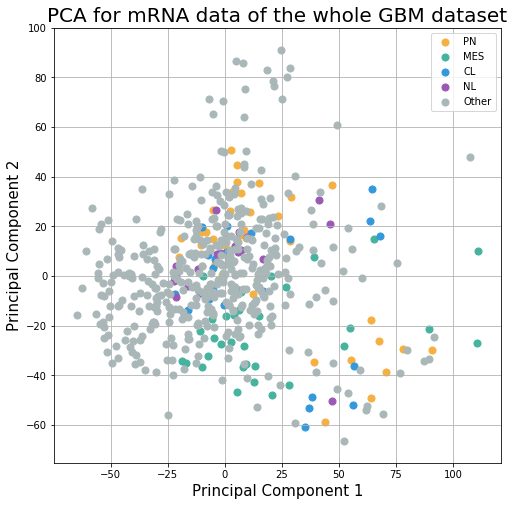

In [31]:
pca = decomposition.PCA(n_components=2)
PC = pca.fit_transform(mRNAArray.values)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
targets=["PN","MES","CL","NL","Other"]
colors = ["#F5B041", '#45B39D', '#3498DB',"#9B59B6","#AAB7B8"]
ax.set_title('PCA for mRNA data of the whole GBM dataset', fontsize = 20)
for target,color in zip(targets,colors):
    indicesToKeep = result['target'] == target
    ax.scatter(PC[indicesToKeep,0]
               , PC[indicesToKeep,1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()   


#### PCA with the Verhaak signature and samples only

In [32]:
col=Veerhak_GS["Gene Symbol"].tolist()
ind=[x for x in d.values() if x!=[]]

In [33]:
Verhaak=mRNAArray.loc[ind,col]
Verhaak_description=Verhaak.describe()
Verhaak_description.head(10)

,CDKN1B,EPB41,CLGN,PDE10A,RALGPS2,TAF5,ACTR1A,PELI1,ZNF804A,PPM1D,...,BLVRB,CYBRD1,ARHGAP29,CNN2,TLR4,PIGP,UCP2,FOLR2,TEC,S100A13
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,...,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000
mean,9.021172,3.904752,4.719425,3.867332,4.114339,5.687017,7.221512,7.660010,4.881805,7.116965,...,7.872586,6.830749,7.741588,5.983791,5.192825,8.670902,7.999421,6.784115,4.043583,9.653878
std,0.702763,0.118999,1.191288,0.147529,0.262248,0.627258,0.604404,0.808335,0.979293,0.864333,...,0.891106,1.154619,1.236457,0.871394,0.730878,0.752051,0.972877,1.183132,0.200514,1.265317
min,7.009025,3.654806,3.491484,3.579356,3.675243,4.590489,5.755733,4.031201,3.784853,4.494558,...,4.894455,3.992336,3.687281,4.838287,3.979526,6.136927,5.624387,4.707189,3.664032,6.183673
25%,8.693191,3.824157,3.822804,3.775642,3.915323,5.307380,6.828434,7.348653,4.231852,6.593421,...,7.273753,6.038151,6.891646,5.296441,4.658260,8.397871,7.399052,5.994475,3.919836,9.144458
50%,9.078702,3.890363,4.265387,3.839606,4.064425,5.527033,7.233382,7.832412,4.473392,7.191845,...,7.969191,6.901032,7.811098,5.701330,5.073825,8.753099,8.034319,6.539640,4.028372,9.888067
75%,9.478976,3.969050,5.298485,3.916768,4.253872,5.932037,7.631871,8.144697,5.282582,7.623496,...,8.516781,7.761323,8.560303,6.727486,5.626072,9.086074,8.593998,7.481887,4.146975,10.547650
max,10.622380,4.297368,9.355224,4.257907,5.434992,7.593427,9.358317,9.107440,8.825149,9.062477,...,9.587573,9.170467,11.541890,8.337823,7.246785,10.420360,10.787290,10.245674,5.103934,12.041720


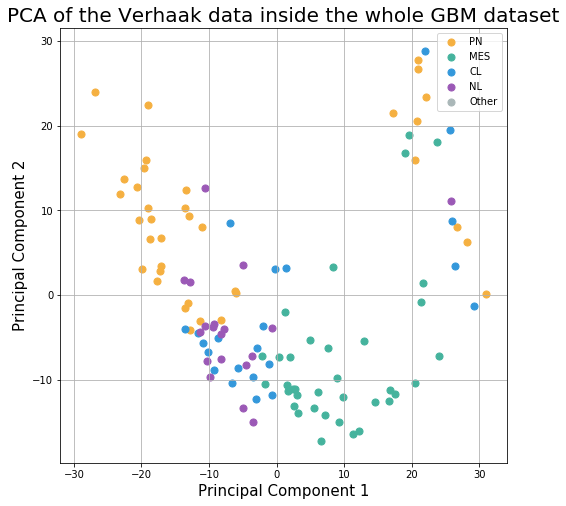

In [34]:
#Code to mark the samples in mRNAArray as one of the four subclasses of GBM or as other
result=list()
for i in Verhaak.index.tolist():
    if i in labels["Hybridization REF"].tolist():
        index=labels["Hybridization REF"].tolist().index(i)
        result.append(labels.loc[index,"Subtype"])
    else:
        result.append("Other")
result=pd.DataFrame(result,columns=["target"])
result.head()

#Code to build the PCA plot
pca = decomposition.PCA(n_components=2)
PC = pca.fit_transform(Verhaak.values)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
targets=["PN","MES","CL","NL","Other"]
colors = ["#F5B041", '#45B39D', '#3498DB',"#9B59B6","#AAB7B8"]
ax.set_title('PCA of the Verhaak data inside the whole GBM dataset', fontsize = 20)
for target,color in zip(targets,colors):
    indicesToKeep = result['target'] == target
    ax.scatter(PC[indicesToKeep,0]
               , PC[indicesToKeep,1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()   


In [35]:
series=pd.Series(data=result["target"].values,index=Verhaak.index)

In [36]:
#The function getDiffExpressedGenes which is used to build the heatmap described in :
#https://bioconductor.org/packages/release/bioc/vignettes/RTCGAToolbox/inst/doc/RTCGAToolbox-vignette.html#reproducing-brca-results-from-original-manuscript
# Needs a control sample (i guess the positive and negative values come from a logFC)


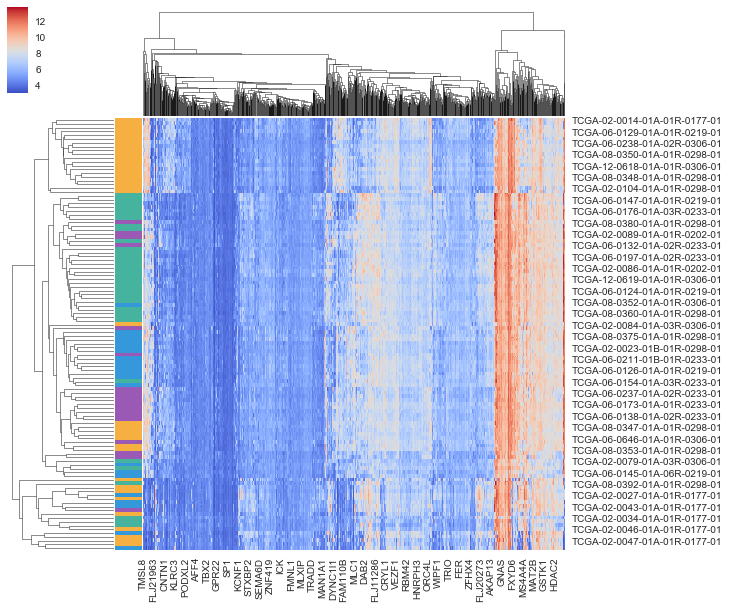

In [37]:
sns.set(color_codes=True)
lut = {"PN":"#F5B041","MES":'#45B39D',"CL":'#3498DB',"NL":"#9B59B6"}
row_colors = series.map(lut)
g = sns.clustermap(Verhaak,cmap="coolwarm", row_colors=row_colors)

## MicroArray miRNA

In [38]:
miRNA= pd.read_csv(folder_Firebrowse_GBM+'gdac.broadinstitute.org_GBM.Merge_mirna__h_mirna_8x15k__unc_edu__Level_3__unc_DWD_Batch_adjusted__data.Level_3.2016012800.0.0.csv', sep=",",header=0,index_col=0)
miRNA=miRNA.apply(pd.to_numeric)
miRNA=miRNA.transpose()
miRNA.head()

,15E1.2,2'-PDE,7A5,A1BG,A2BP1,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,...,hCG_40738,psiTPTE22,tAKR,tcag7.1015,tcag7.1017,tcag7.1136,tcag7.1260,tcag7.1314,tcag7.23,tcag7.350
TCGA-02-0001-01C-01R-0179-07,-1.0698,0.37135,-1.584333,0.708875,2.420750,2.8104,0.304667,-0.0756,-0.376750,0.203333,...,-0.268000,1.4360,0.2534,-0.2184,0.176667,1.7288,-0.479333,2.2818,-0.2500,-0.3016
TCGA-02-0003-01A-01R-0179-07,-1.3194,-0.00290,-0.587333,0.675500,2.489875,2.3450,0.984667,0.0338,-0.749250,0.336667,...,-0.351000,2.2382,0.0684,-0.9972,0.359167,1.0740,-0.660667,1.4026,-0.5005,-0.8966
TCGA-02-0006-01B-01R-0179-07,-1.4202,-0.25835,-0.679000,1.049125,1.367250,3.3224,1.362000,-0.0168,0.523875,0.204000,...,-0.386000,2.9540,0.0616,-0.6506,0.319500,1.1010,-0.737000,1.1136,-0.3985,-1.0674
TCGA-02-0007-01A-01R-0179-07,-1.4334,-0.32770,-0.975000,0.546500,0.631375,-0.4414,1.424000,-0.0508,-1.173000,0.160333,...,-0.363667,1.8846,0.0418,-0.6294,-0.020833,-0.1980,-1.513000,0.7186,-0.7440,-1.4192
TCGA-02-0009-01A-01R-0179-07,-2.3584,0.01290,-2.224000,-1.277375,-1.068000,1.9466,0.606000,-0.2144,-1.266125,0.399667,...,-0.041667,1.6222,0.0832,-0.7676,0.532000,2.6350,-0.352333,1.8652,-1.8350,-1.2798


In [39]:
miRNA.shape

(101, 17814)

In [40]:
miRNA_description=miRNA.describe()
miRNA_description.head(10)

,15E1.2,2'-PDE,7A5,A1BG,A2BP1,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,...,hCG_40738,psiTPTE22,tAKR,tcag7.1015,tcag7.1017,tcag7.1136,tcag7.1260,tcag7.1314,tcag7.23,tcag7.350
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,...,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,-1.141554,0.050626,-1.273733,0.488119,1.299470,2.085127,0.853594,0.029395,-0.387543,0.205502,...,-0.340040,1.540380,0.143616,-0.436562,0.314577,1.087206,-0.489294,1.431931,-0.299149,-0.907739
std,0.653133,0.312983,0.508053,0.824981,1.552904,1.072903,0.481785,0.242760,0.513630,0.136387,...,0.412551,0.893315,0.154980,0.413864,0.315910,1.042795,0.495423,0.928824,0.516514,0.515568
min,-2.358400,-0.762200,-2.586000,-1.464125,-1.068000,-0.853800,-0.136000,-0.494000,-1.682625,-0.305000,...,-2.054333,-0.654400,-0.139800,-1.304000,-0.416500,-1.497200,-1.921667,-1.254600,-1.835000,-2.097000
25%,-1.535600,-0.130000,-1.575000,-0.076500,0.198500,1.340600,0.515667,-0.100600,-0.626000,0.132667,...,-0.588333,0.978200,0.023600,-0.747200,0.086667,0.371200,-0.790667,0.932000,-0.597500,-1.328400
50%,-1.246600,0.056050,-1.308000,0.472625,1.049250,1.991800,0.798667,-0.006000,-0.460500,0.215333,...,-0.324333,1.490200,0.134200,-0.456800,0.297500,1.027600,-0.516667,1.402600,-0.351000,-0.890800
75%,-0.749200,0.252250,-0.938000,1.031625,2.077375,2.810400,1.098667,0.131600,-0.103500,0.290333,...,-0.087333,2.124000,0.220200,-0.139000,0.542167,1.728800,-0.195000,2.125200,-0.016000,-0.523200
max,1.143600,0.880200,0.044667,2.876875,5.894375,5.784400,2.210667,1.133200,1.491250,0.585000,...,0.964333,3.570400,0.688250,0.514600,1.373167,3.608800,0.820667,3.972800,0.853500,0.215400


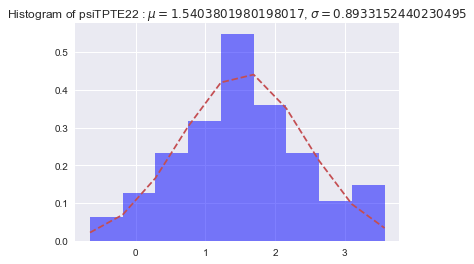

In [41]:
hist_col("psiTPTE22",miRNA,miRNA_description)

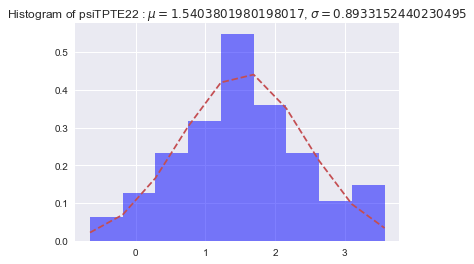

In [42]:
hist_col("psiTPTE22",miRNA,miRNA_description)

In [43]:
miRNA.size-np.isfinite(miRNA).sum().sum()

1

In [44]:
i=(miRNA.isnull().any(axis=0))
i[i==True]


PCDHGB6    True
dtype: bool

In [45]:
j=miRNA.isnull().any(axis=1)
j[j==True]


TCGA-06-0147-01A-02R-0229-07    True
dtype: bool

In [46]:
type(miRNA.loc["TCGA-06-0147-01A-02R-0229-07","PCDHGB6"])

numpy.float64

In [47]:
miRNA["PCDHGB6"]["TCGA-06-0147-01A-02R-0229-07"]=np.nan

#### Data imputation

In [48]:
#There is one NAN in the miRNA dataframe in gene PCDHGB6 and patient TCGA-06-0147-01A-02R-0229-07

In [49]:
#Code to impute the NaN in the miRNA gene expression matrix
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values = np.nan, strategy = 'mean', axis =0)
imputer = imputer.fit(miRNA)
miRNAvalues = imputer.transform(miRNA)
miRNAvalues=pd.DataFrame(miRNAvalues,columns=miRNA.columns,index=miRNA.index)

In [50]:
miRNA.update(miRNAvalues)

In [51]:
miRNA.loc["TCGA-06-0147-01A-02R-0229-07","PCDHGB6"]

0.22317999999999988

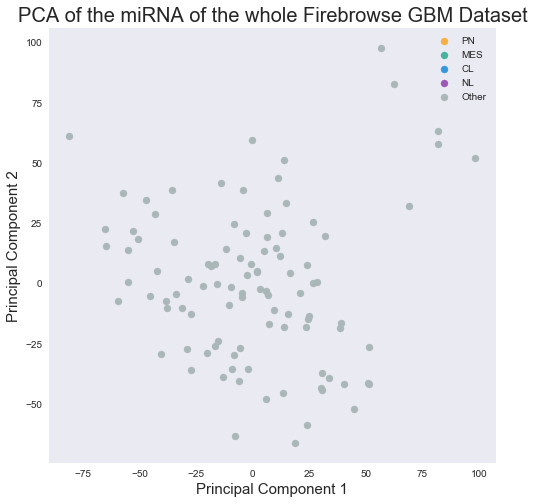

In [103]:
#Code to mark the samples in mRNAArray as one of the four subclasses of GBM or as other, and assign a color to them
result=list()
for i in miRNA.index.tolist():
    if i in labels["Hybridization REF"].tolist():
        index=labels["Hybridization REF"].tolist().index(i)
        result.append(labels.loc[index,"Subtype"])
    else:
        result.append("Other")
result=pd.DataFrame(result,columns=["target"])

pca = decomposition.PCA(n_components=2)
PC = pca.fit_transform(miRNA)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
targets=["PN","MES","CL","NL","Other"]
colors = ["#F5B041", '#45B39D', '#3498DB',"#9B59B6","#AAB7B8"]
ax.set_title('PCA of the miRNA of the whole Firebrowse GBM Dataset', fontsize = 20)
for target,color in zip(targets,colors):
    indicesToKeep = result['target'] == target
    ax.scatter(PC[indicesToKeep,0]
               , PC[indicesToKeep,1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()   

In [53]:
miRNA.shape

(101, 17814)

In [ ]:
#miRNA dataset seems to have been already mapped to mRNA!

In [54]:
#There seem to be no patients from the Verhaak dataset on the miRNA from Firebrowse GBM

In [55]:
#Firehose documentation: miRNASeqGene miRNA expression data from matrix smallRNAseq

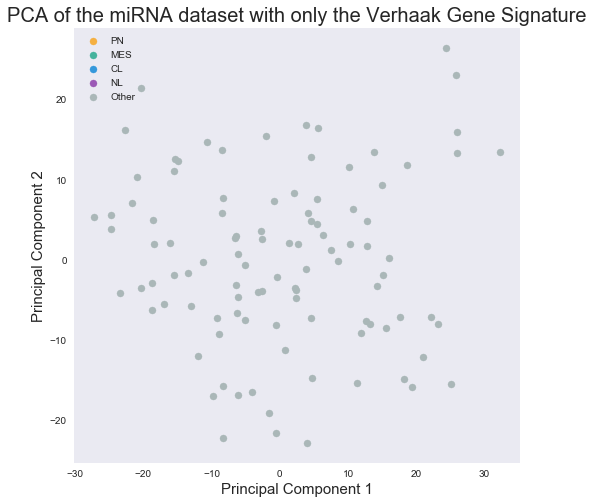

In [56]:
miRNA_Verhaak_GS=miRNA.loc[:,Verhaak.columns]
#Code to mark the samples in mRNAArray as one of the four subclasses of GBM or as other, and assign a color to them
result=list()
for i in miRNA_Verhaak_GS.index.tolist():
    if i in labels["Hybridization REF"].tolist():
        index=labels["Hybridization REF"].tolist().index(i)
        result.append(labels.loc[index,"Subtype"])
    else:
        result.append("Other")
result=pd.DataFrame(result,columns=["target"])

pca = decomposition.PCA(n_components=2)
PC = pca.fit_transform(miRNA_Verhaak_GS)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
targets=["PN","MES","CL","NL","Other"]
colors = ["#F5B041", '#45B39D', '#3498DB',"#9B59B6","#AAB7B8"]
ax.set_title('PCA of the miRNA dataset with only the Verhaak Gene Signature', fontsize = 20)
for target,color in zip(targets,colors):
    indicesToKeep = result['target'] == target
    ax.scatter(PC[indicesToKeep,0]
               , PC[indicesToKeep,1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()  

In [126]:
miRNA_Verhaak_GS.shape

(101, 840)

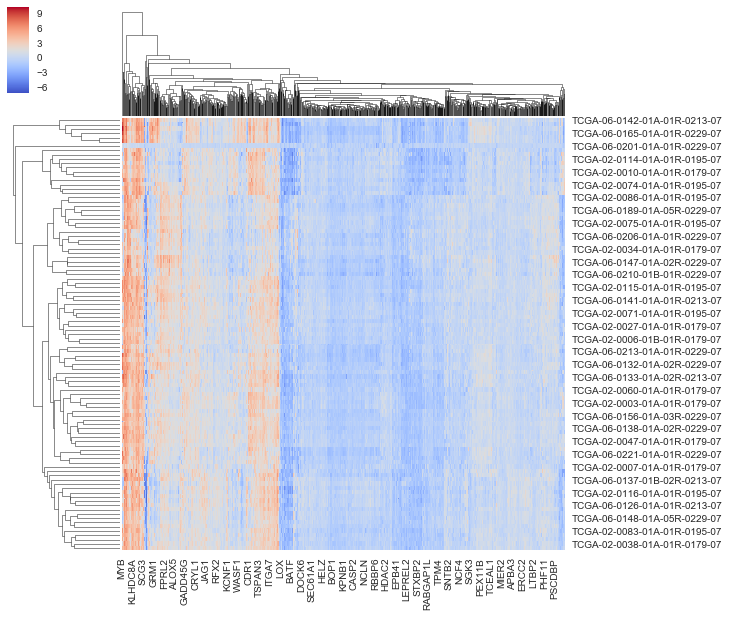

In [57]:
series=pd.Series(data=result["target"].values,index=miRNA_Verhaak_GS.index)
sns.set(color_codes=True)
lut = {"PN":"#F5B041","MES":'#45B39D',"CL":'#3498DB',"NL":"#9B59B6"}
row_colors = series.map(lut)
g = sns.clustermap(miRNA_Verhaak_GS,cmap="coolwarm")

## Methylation

In [58]:
Methylation= pd.read_csv(folder_Firebrowse_GBM+'gdac.broadinstitute.org_GBM.Merge_methylation__humanmethylation27__jhu_usc_edu__Level_3__within_bioassay_data_set_function__data.Level_3.2016012800.0.0.csv', sep=",",header=0,index_col=0)
Methylation=Methylation.drop(columns=["Gene_Symbol","Chromosome","Genomic_Coordinate"])
Methylation=Methylation.transpose()
Methylation=Methylation.apply(pd.to_numeric)
Methylation.tail()

,cg00000292,cg00002426,cg00003994,cg00005847,cg00006414,cg00007981,cg00008493,cg00008713,cg00009407,cg00010193,...,cg27653134,cg27654142,cg27655855,cg27655905,cg27657249,cg27657283,cg27661264,cg27662379,cg27662877,cg27665659
TCGA-41-2575-01A-01D-0915-05,0.064723,0.068986,0.026795,0.614811,NaN,0.025353,0.985818,0.016063,0.011510,0.563469,...,0.451640,0.014644,NaN,0.016486,0.204148,0.027730,0.106203,0.010861,0.015325,0.013108
TCGA-41-3392-01A-01D-0915-05,0.315678,0.054030,0.032365,0.165496,NaN,0.029732,0.977554,0.016468,0.012365,0.568800,...,0.852199,0.026460,NaN,0.020993,0.194951,0.056177,0.371132,0.012617,0.017352,0.018702
TCGA-41-3393-01A-01D-1228-05,0.704422,0.286588,0.029960,0.615784,NaN,0.060207,0.989703,0.016008,0.008809,0.608759,...,0.713776,0.011529,NaN,0.021416,0.239541,0.036686,0.498269,0.011290,0.022090,0.012242
TCGA-41-3915-01A-01D-1228-05,0.475091,0.192033,0.031654,0.531287,NaN,0.047330,0.991061,0.013004,0.009364,0.544424,...,0.654430,0.015106,NaN,0.028958,0.260744,0.039754,0.324399,0.010209,0.033838,0.015145
TCGA-41-4097-01A-01D-1228-05,0.800415,0.313302,0.054829,0.434784,NaN,0.074909,0.989285,0.012309,0.009513,0.525144,...,0.684626,0.018334,NaN,0.031740,0.223187,0.031895,0.313513,0.010630,0.020091,0.019885


In [59]:
Methylation.shape

(285, 27578)

In [60]:
Methylation_description=Methylation.describe()
Methylation_description.head(10)

,cg00000292,cg00002426,cg00003994,cg00005847,cg00006414,cg00007981,cg00008493,cg00008713,cg00009407,cg00010193,...,cg27653134,cg27654142,cg27655855,cg27655905,cg27657249,cg27657283,cg27661264,cg27662379,cg27662877,cg27665659
count,284.000000,284.000000,285.000000,285.000000,0.0,285.000000,285.000000,284.000000,285.000000,285.000000,...,285.000000,285.000000,0.0,285.000000,284.000000,285.000000,285.000000,285.000000,285.000000,285.000000
mean,0.557659,0.234094,0.046670,0.495549,NaN,0.026870,0.986443,0.064786,0.020769,0.582032,...,0.744555,0.022993,NaN,0.029872,0.166230,0.041176,0.370081,0.013549,0.022271,0.021745
std,0.213706,0.213619,0.071140,0.252183,NaN,0.017966,0.003619,0.126455,0.021149,0.071417,...,0.158399,0.042348,NaN,0.011721,0.062808,0.028233,0.109226,0.005181,0.008564,0.015511
min,0.034926,0.018526,0.010619,0.042700,NaN,0.009923,0.975969,0.005194,0.005925,0.348549,...,0.103523,0.005541,NaN,0.014289,0.062724,0.010516,0.032407,0.007967,0.011938,0.005079
25%,0.411882,0.084078,0.020358,0.277266,NaN,0.016560,0.984399,0.012372,0.008829,0.544424,...,0.673565,0.013187,NaN,0.021416,0.120518,0.026167,0.334832,0.010221,0.016076,0.013831
50%,0.578104,0.160511,0.027209,0.527246,NaN,0.023618,0.987019,0.016734,0.010316,0.575911,...,0.783463,0.016145,NaN,0.025774,0.162849,0.034601,0.380396,0.011417,0.019305,0.017994
75%,0.712989,0.299616,0.040577,0.693298,NaN,0.030373,0.989202,0.028905,0.014181,0.613832,...,0.855223,0.021763,NaN,0.035012,0.207241,0.046390,0.423415,0.015645,0.026573,0.023992
max,0.933703,0.939186,0.641906,0.954125,NaN,0.181439,0.994214,0.800032,0.090346,0.860244,...,0.962109,0.441766,NaN,0.081153,0.495971,0.260215,0.857669,0.034135,0.054804,0.146250


In [110]:
(Methylation.size-Methylation.isnull().sum().sum())/Methylation.size

0.9041755887288749

In [109]:
#Many Columns entries are null! (710.000 aprox), which is 90% approx

7859730

In [61]:
#Should I do Imputation on the data to try to plot it? Which type of Imputation?

## CopyNumber

In [62]:
#GISTIC:all_data_by_genes.txt output data. This data is a gene-level table of copy number values for all samples. 
#The returned copy number values are in units (copy number - 2) so that no amplification or deletion is 0, genes 
#with amplifications have positive values, and genes with deletions are negative values. The data are converted 
#from marker level to gene level using the extreme method: a gene is assigned the greatest amplification or the 
#least deletion value among the markers it covers. Results may be filtered by cohort, gene, or barcode, but at 
#least one gene or barcode must be supplied.
#Other datasets available are: Threshold(no amplification or deletion above a certain thershold) and Peaks

Genomic Identification of Significant Targets in Cancer (GISTIC), for identifying regions of aberration that are more likely to drive cancer pathogenesis. The method identifies those regions of the genome that are aberrant more often than would be expected by chance, with greater weight given to high-amplitude events (high-level copy-number gains or homozygous deletions) that are less likely to represent random aberrations.

In [63]:
CopyNumber= pd.read_csv(folder_Firebrowse_GBM+'GISTIC_AllByGene.csv', sep=",",header=0,index_col=1)
CopyNumber=CopyNumber.drop(columns=["Locus.ID","Cytoband","Unnamed: 0"])
CopyNumber.head()
CopyNumber=CopyNumber.transpose()
new_index=pd.Series([w.replace(".","-") for w in CopyNumber.index.tolist()])
CopyNumber.set_index(new_index,inplace=True)
CopyNumber=CopyNumber.apply(pd.to_numeric)
CopyNumber.head()

Gene.Symbol,ACAP3,ACTRT2,AGRN,ANKRD65,ATAD3A,ATAD3B,ATAD3C,AURKAIP1,B3GALT6,C1orf159,...,SMIM9,SNORA36A,SNORA56,TMLHE,VBP1,IL9R|ENSG00000124334.12,SPRY3|ENSG00000168939.6,VAMP7|ENSG00000124333.10,WASH6P|ENSG00000182484.10,WASIR1|ENSG00000185203.7
TCGA-02-0001-01C-01D-0182-01,0.242,0.242,0.242,0.242,0.242,0.242,0.242,0.242,0.242,0.242,...,0.076,0.076,0.076,0.076,0.076,0.076,0.076,0.076,0.076,0.076
TCGA-02-0003-01A-01D-0182-01,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,...,-0.071,-0.071,-0.071,-0.071,-0.071,-0.071,-0.071,-0.071,-0.071,-0.071
TCGA-02-0006-01B-01D-0182-01,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,...,-0.052,-0.052,-0.052,-0.052,-0.052,-0.052,-0.052,-0.052,-0.052,-0.052
TCGA-02-0007-01A-01D-0182-01,-0.072,-0.072,-0.072,-0.072,-0.072,-0.072,-0.072,-0.072,-0.072,-0.072,...,-0.184,-0.184,-0.184,-0.184,-0.184,-0.184,-0.184,-0.184,-0.184,-0.184
TCGA-02-0009-01A-01D-0182-01,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,...,-0.058,-0.058,-0.058,-0.058,-0.058,-0.058,-0.058,-0.058,-0.058,-0.058


In [64]:
CopyNumber.shape

(577, 24776)

In [65]:
CopyNumber_description=CopyNumber.describe()
CopyNumber_description.head(10)

Gene.Symbol,ACAP3,ACTRT2,AGRN,ANKRD65,ATAD3A,ATAD3B,ATAD3C,AURKAIP1,B3GALT6,C1orf159,...,SMIM9,SNORA36A,SNORA56,TMLHE,VBP1,IL9R|ENSG00000124334.12,SPRY3|ENSG00000168939.6,VAMP7|ENSG00000124333.10,WASH6P|ENSG00000182484.10,WASIR1|ENSG00000185203.7
count,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,...,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000
mean,-0.022818,-0.022818,-0.022818,-0.022818,-0.022818,-0.022818,-0.022818,-0.022818,-0.022818,-0.022818,...,-0.040938,-0.040938,-0.040938,-0.040938,-0.040938,-0.040938,-0.040938,-0.040938,-0.040938,-0.040938
std,0.294683,0.294683,0.294683,0.294683,0.294683,0.294683,0.294683,0.294683,0.294683,0.294683,...,0.168788,0.168788,0.168788,0.168788,0.168788,0.168788,0.168788,0.168788,0.168788,0.168788
min,-1.083000,-1.083000,-1.083000,-1.083000,-1.083000,-1.083000,-1.083000,-1.083000,-1.083000,-1.083000,...,-0.805000,-0.805000,-0.805000,-0.805000,-0.805000,-0.805000,-0.805000,-0.805000,-0.805000,-0.805000
25%,-0.035000,-0.035000,-0.035000,-0.035000,-0.035000,-0.035000,-0.035000,-0.035000,-0.035000,-0.035000,...,-0.089000,-0.089000,-0.089000,-0.089000,-0.089000,-0.089000,-0.089000,-0.089000,-0.089000,-0.089000
50%,0.003000,0.003000,0.003000,0.003000,0.003000,0.003000,0.003000,0.003000,0.003000,0.003000,...,-0.041000,-0.041000,-0.041000,-0.041000,-0.041000,-0.041000,-0.041000,-0.041000,-0.041000,-0.041000
75%,0.045000,0.045000,0.045000,0.045000,0.045000,0.045000,0.045000,0.045000,0.045000,0.045000,...,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000
max,1.228000,1.228000,1.228000,1.228000,1.228000,1.228000,1.228000,1.228000,1.228000,1.228000,...,1.797000,1.797000,1.797000,1.797000,1.797000,1.797000,1.797000,1.797000,1.797000,1.797000


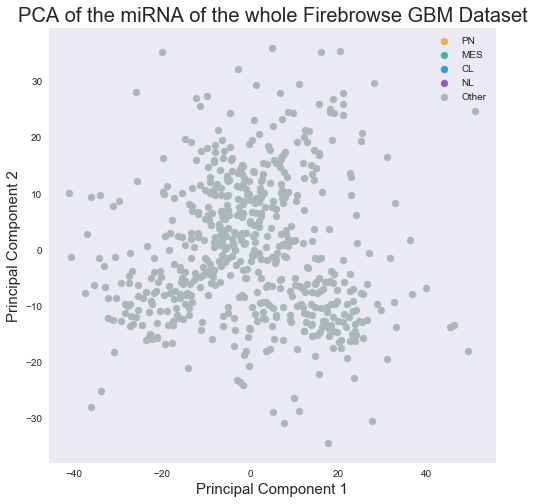

In [112]:
#Code to mark the samples in mRNAArray as one of the four subclasses of GBM or as other, and assign a color to them
result=list()
for i in CopyNumber.index.tolist():
    if i in labels["Hybridization REF"].tolist():
        index=labels["Hybridization REF"].tolist().index(i)
        result.append(labels.loc[index,"Subtype"])
    else:
        result.append("Other")
result=pd.DataFrame(result,columns=["target"])

pca = decomposition.PCA(n_components=2)
PC = pca.fit_transform(CopyNumber)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
targets=["PN","MES","CL","NL","Other"]
colors = ["#F5B041", '#45B39D', '#3498DB',"#9B59B6","#AAB7B8"]
ax.set_title('PCA of the miRNA of the whole Firebrowse GBM Dataset', fontsize = 20)
for target,color in zip(targets,colors):
    indicesToKeep = result['target'] == target
    ax.scatter(PC[indicesToKeep,0]
               , PC[indicesToKeep,1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()   

In [67]:
#It seems like none of the Verhaak samples are in this dataset

## RNASeq Data

In [68]:
#This data I couldn't obtain directly from RTCGA, so I downloaded it from here:http://firebrowse.org/?cohort=GBM

In [69]:
RNASeq=pd.read_csv(folder_Firebrowse_GBM+'GBM.rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.data.txt', sep="\t",header=0,index_col=0)
RNASeq=RNASeq.drop(index="gene_id")
RNASeq=RNASeq.apply(pd.to_numeric)
RNASeq=RNASeq.transpose()
RNASeq.head()

Hybridization REF,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,...,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,psiTPTE22|387590,tAKR|389932
TCGA-02-0047-01A-01R-1849-01,0.0,3.0732,6.7611,54.7036,886.3210,0.0,232.9512,0.0000,0.0,0.0,...,65.1526,356.4953,1108.8233,0.6146,1207.1668,3867.9738,1397.0927,603.5834,6.7611,0.0
TCGA-02-0055-01A-01R-1849-01,0.0,0.0000,15.6973,31.3945,885.7744,0.0,162.0182,0.5606,0.0,0.0,...,42.6069,280.3083,607.7085,5.0456,924.4569,11481.4296,606.0266,718.1500,12.3336,0.0
TCGA-02-2483-01A-01R-1849-01,0.0,2.9467,13.9398,60.3441,1234.8285,0.0,135.0923,0.0000,0.0,0.0,...,19.4195,406.1214,866.2797,44.3272,1208.6544,5066.8074,832.0844,705.4354,398.9446,0.0
TCGA-02-2485-01A-01R-1849-01,0.0,15.9952,14.9571,91.8238,470.0000,0.0,417.6190,1.9048,0.0,0.0,...,53.8095,274.2857,1345.7143,0.0000,1070.0000,5090.9524,1139.5238,700.4762,15.7143,0.0
TCGA-02-2486-01A-01R-1849-01,0.0,5.5610,4.8049,62.5366,546.3415,0.0,276.2195,0.0000,0.0,0.0,...,31.7073,198.1707,652.4390,0.0000,689.6341,7800.0000,627.4390,527.4390,69.5122,0.0


In [70]:
RNASeq_description=RNASeq.describe()
RNASeq_description.head(9)

Hybridization REF,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,...,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,psiTPTE22|387590,tAKR|389932
count,171.000000,171.000000,171.000000,171.000000,171.000000,171.0,171.000000,171.000000,171.0,171.0,...,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000
mean,0.034032,6.636998,9.940446,60.105196,653.272607,0.0,425.840155,0.740589,0.0,0.0,...,55.685537,372.700150,1028.670229,2.914652,1162.056123,7396.001312,1085.065123,680.302417,77.312954,0.025412
std,0.159486,5.428784,5.611120,19.986512,226.435829,0.0,313.874665,0.887412,0.0,0.0,...,22.426281,127.368987,285.551154,7.409476,381.244404,4140.673690,440.035783,169.426223,358.202071,0.200100
min,0.000000,0.000000,0.000000,27.088000,331.168100,0.0,33.483600,0.000000,0.0,0.0,...,4.994800,167.095100,443.066500,0.000000,506.812000,1239.196000,278.110200,283.216900,0.000000,0.000000
25%,0.000000,2.641250,5.868000,46.769300,506.025450,0.0,208.775050,0.000000,0.0,0.0,...,41.743850,284.719800,843.070550,0.441400,942.132350,4341.082300,811.804400,565.331600,7.887550,0.000000
50%,0.000000,5.491800,9.786600,56.298000,614.026500,0.0,342.897100,0.513300,0.0,0.0,...,53.809500,354.293400,1038.876000,1.061100,1116.333700,6367.216100,1047.295000,664.759400,13.882700,0.000000
75%,0.000000,9.674400,13.208150,70.633550,760.262300,0.0,560.077900,1.106850,0.0,0.0,...,67.162600,432.348400,1208.172500,2.553250,1260.743950,9797.034550,1343.134150,782.039250,27.307600,0.000000
max,1.175100,27.989300,28.799300,135.060300,2140.303700,0.0,2078.431400,5.012500,0.0,0.0,...,157.726600,1027.236400,2272.025800,68.503400,3468.534200,22510.284800,3456.869700,1364.511700,4007.687900,2.359900


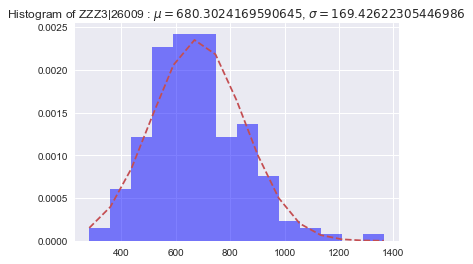

In [71]:
hist_col("ZZZ3|26009",RNASeq,RNASeq_description)

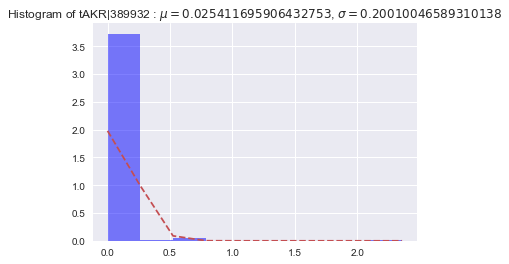

In [72]:
hist_col("tAKR|389932",RNASeq,RNASeq_description)

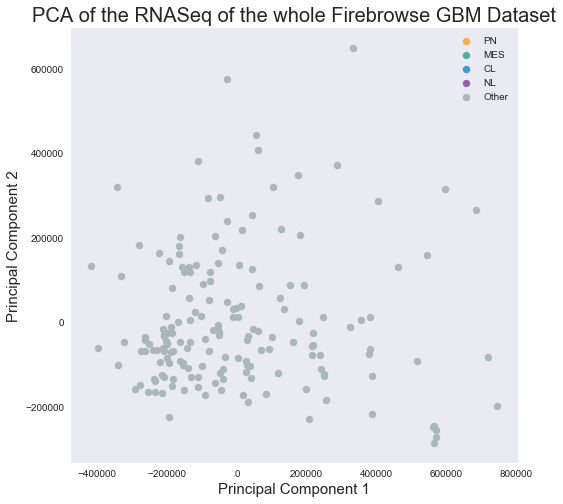

In [118]:
#Code to mark the samples in mRNAArray as one of the four subclasses of GBM or as other, and assign a color to them
result=list()
for i in RNASeq.index.tolist():
    if i in labels["Hybridization REF"].tolist():
        index=labels["Hybridization REF"].tolist().index(i)
        result.append(labels.loc[index,"Subtype"])
    else:
        result.append("Other")
result=pd.DataFrame(result,columns=["target"])

pca = decomposition.PCA(n_components=2)
PC = pca.fit_transform(RNASeq)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
targets=["PN","MES","CL","NL","Other"]
colors = ["#F5B041", '#45B39D', '#3498DB',"#9B59B6","#AAB7B8"]
ax.set_title('PCA of the RNASeq of the whole Firebrowse GBM Dataset', fontsize = 20)
for target,color in zip(targets,colors):
    indicesToKeep = result['target'] == target
    ax.scatter(PC[indicesToKeep,0]
               , PC[indicesToKeep,1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()  